# Rasterio Cookbook
In this notebook we use some utilities from the [rasterio](https://rasterio.readthedocs.io/en/stable/) Python package for raster data that is somewhat easier to use than [GDAL](https://gdal.org/en/stable/).

In [2]:
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print("Matplotlib version: %s"%matplotlib.__version__)
print("rasterio version: %s"%rasterio.__version__)

NumPy version: 1.26.4
Matplotlib version: 3.8.4
rasterio version: 1.4.3


We import some functions and constants developed for the project

In [3]:
from scripts.bigearthnetv2_data_preparation import *

Path to BigEarthNetv2 dataset: data/BigEarthNet-S2


In development phase we have to execute the script to use the updated functions without restarting the notebook

In [4]:
%run -i scripts/bigearthnetv2_data_preparation.py

Path to BigEarthNetv2 dataset: data/BigEarthNet-S2


In [5]:
images_list = list_data_files(IMAGES_DATA_DIR)

In [6]:
img_path = images_list[0][0][0]

## Raster dataset attributes

In [7]:
def get_raster_attributes(img_path):
    width = 0.0
    height = 0.0
    d_type = None
    crs = None
    transform = None
    with rasterio.open(img_path) as dataset:
        d_types = dataset.dtypes[0]
        print('dtypes: {}'.format(d_types))
        print('Number of bands: {:d}'.format(dataset.count))
        width = dataset.width
        height = dataset.height
        print('Band width: {:d}, band height: {:d}'.format(width, height))
        transform = dataset.transform
        print('Dataset affine transform:\n {}'.format(transform))
        crs = dataset.crs
        print('EPSG Coordinates Reference System: {}'.format(crs))
        bb_left = dataset.bounds.left
        bb_bottom = dataset.bounds.bottom
        bb_right = dataset.bounds.right
        bb_top = dataset.bounds.top
        print('Bounding box \n left: {:.2f}, \n bottom: {:.2f}, \n right: {:.2f}, \n top: {:.2f}'.format(bb_left, bb_bottom, bb_right, bb_top))                                                   
    return width, height, d_type, transform

In [8]:
get_raster_attributes(img_path)

dtypes: uint16
Number of bands: 1
Band width: 120, band height: 120
Dataset affine transform:
 | 10.00, 0.00, 331200.00|
| 0.00,-10.00, 5331600.00|
| 0.00, 0.00, 1.00|
EPSG Coordinates Reference System: EPSG:32633
Bounding box 
 left: 331200.00, 
 bottom: 5330400.00, 
 right: 332400.00, 
 top: 5331600.00


(120,
 120,
 None,
 Affine(10.0, 0.0, 331200.0,
        0.0, -10.0, 5331600.0))

## Reading raster data

In [9]:
def read_raster_data(img_path):
    with rasterio.open(img_path) as dataset:
        num_bands = dataset.count
        for b in range(1, num_bands + 1):
            band = dataset.read(b)
            rows, cols = band.shape
            m = np.mean(band)
            std = np.std(band)
            print('Band {:d} rows: {:d}, cols: {:d}, mean: {:.2f}, std: {:.2f}'.format(b, rows, cols, m, std))

In [10]:
read_raster_data(img_path)

Band 1 rows: 120, cols: 120, mean: 341.58, std: 196.76


## Coordinates transform

In [11]:
import rasterio.features
import rasterio.warp

def print_coords_transform(img_path):
    with rasterio.open(img_path) as dataset:

        # Read the dataset's valid data mask as a ndarray.
        mask = dataset.dataset_mask()

        # Extract feature shapes and values from the array.
        for geom, val in rasterio.features.shapes(mask, transform=dataset.transform):

            # Transform shapes from the dataset's own coordinate
            # reference system to CRS84 (EPSG:4326).
            geom = rasterio.warp.transform_geom(
                dataset.crs, 'EPSG:4326', geom, precision=6)

            # Print GeoJSON shapes to stdout.
            print(geom)

In [12]:
print_coords_transform(img_path)

{'type': 'Polygon', 'coordinates': [[[12.732009, 48.11527], [12.732483, 48.104482], [12.74859, 48.104799], [12.748119, 48.115587], [12.732009, 48.11527]]]}


## Creating a GeoTIFF RGB image
A GeoTIFF file contains one or more bands and metadata about the bounding box and the coordinates reference system. 

In [13]:
def createGeoTiff(source_path_list, target_path):
    '''
    This function creates a multiband GeoTIFF file from a list of other GeoTIFF files 
    containing one band each. For an RGB file the source list shall contain three bands
    in the RGB order. For Sentinel-2 it is B04, B03, B02. If the target file already exists
    it doesn't create a new one and will return 1, otherwise it will create a new raster
    and will return 0 
    '''
    SUCCESS = 0
    FAILURE = 1
    if (os.path.isfile(target_path)):
        return FAILURE 
        
    band_list = []
    dataset = rasterio.open(source_path_list[0])
    width = dataset.width
    height = dataset.height
    crs = dataset.crs
    transform = dataset.transform
    count = len(source_path_list)

    for raster_path in source_path_list:
        dataset = rasterio.open(raster_path)
        band = dataset.read(1)
        band_list.append(band)
        
        
    with rasterio.open(target_path,
                    mode='w',
                    driver='GTiff',
                    height=height,
                    width=width,
                    count=count,
                    dtype='uint16',
                    crs=crs,
                    transform=transform) as target_dataset:
        band_index = 1
        for band in band_list:
            target_dataset.write(band, band_index)
            band_index += 1
    return SUCCESS

We use the three RGB bands of an image patch in order to create and plot the PNG file

In [15]:
rgb_bands = []
for band in images_list[0][0]:
        rgb_bands.append(band)

In [16]:
createGeoTiff(rgb_bands, 'data/rgb.tif')

0

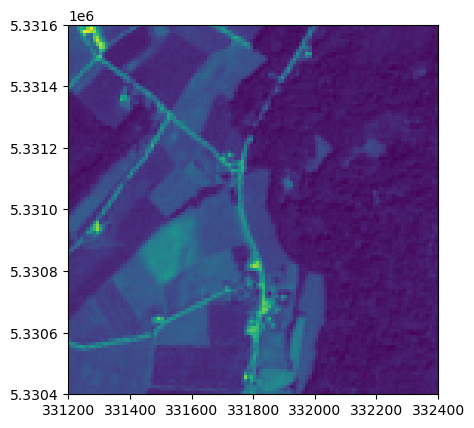

In [17]:
from rasterio.plot import show
src = rasterio.open('data/rgb.tif')
show(src)
src.close()